In [30]:
import os
import matplotlib.pyplot as plt
import string


import gensim
from gensim import models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM

from nltk.stem import SnowballStemmer
from nltk.stem.porter import *

np.random.seed(2018)

In [2]:
notebook_dir = os.getcwd()
rel_path = '../../data/complete_data/statements_cleaned_spy_tnx.csv'

df=pd.read_csv(os.path.join(notebook_dir, rel_path), parse_dates=['date'])

In [3]:
df['contents'] = df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
df

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,SPY: d+4,SPY: d+5,SPY: d+6,SPY: d+7,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,^TNX: d-1,^TNX: d+0
0,1994-02-04,Chairman Alan Greenspan announced today that t...,Alan Greenspan,FOMC Statement,"['SECTION', 'Chairman', 'Alan', 'Greenspan', '...",28.737467,28.083496,28.214291,28.232964,28.345083,28.102180,28.195601,28.232964,28.382442,28.363773,28.195601,28.027443,28.307709,28.232964,27.859268,27.990063,5.758,5.888
1,1994-03-22,Chairman Alan Greenspan announced today that t...,Alan Greenspan,FOMC Statement,"['SECTION', 'Chairman', 'Alan', 'Greenspan', '...",28.170324,28.245501,28.226707,27.888437,27.625326,27.662933,27.117922,26.742073,26.817245,26.403801,26.948797,26.948797,27.080345,26.873617,26.986378,26.948797,6.537,6.435
2,1994-04-18,Chairman Alan Greenspan announced today that t...,Alan Greenspan,FOMC Statement,"['SECTION', 'Chairman', 'Alan', 'Greenspan', '...",26.817245,26.638710,26.676292,26.648111,27.005156,26.976992,27.258863,27.230688,27.033371,27.117922,27.287062,27.258863,27.211891,27.174311,26.911221,26.676292,6.948,7.117
3,1994-05-17,The Federal Reserve today announced two action...,Alan Greenspan,FOMC Statement,"['SECTION', 'Federal', 'Reserve', 'today', 'an...",26.779652,27.174311,27.371637,27.503181,27.399815,27.352842,27.465605,27.540762,27.559557,27.587755,27.550159,27.672316,27.644127,27.803860,27.794476,27.756870,7.232,7.086
4,1994-08-16,The Federal Reserve announced today the follow...,Alan Greenspan,FOMC Statement,"['SECTION', 'Federal', 'Reserve', 'announced',...",28.034971,28.233603,28.214682,28.120092,28.101198,28.072817,28.233603,28.536278,28.460606,28.867315,28.848402,28.924082,28.848402,28.753832,28.630871,28.640335,7.286,7.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",436.076019,435.897186,437.705048,435.579376,434.665497,438.201721,436.046234,438.807648,439.532745,439.175140,439.721466,440.814117,442.135254,442.939850,443.982819,441.072388,1.234,1.261
207,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",432.111908,436.327057,441.628448,442.355896,441.090363,432.201569,432.929016,427.637634,432.719757,427.139374,431.583740,433.377441,437.124268,436.327057,433.168182,432.101929,1.324,1.336
208,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",460.282898,463.093048,465.275391,466.889709,467.288300,465.743744,461.996887,462.146362,465.634094,465.793549,467.637085,466.501099,468.085510,467.248474,465.933075,466.550903,1.549,1.579
209,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",461.737793,468.952454,464.816986,459.869995,454.980011,463.059998,467.690002,470.600006,477.260010,476.869995,477.480011,476.160004,474.959991,477.709991,477.549988,468.380005,1.438,1.463


# Preprocessing

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phzeller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
stemmer = SnowballStemmer('english')

In [6]:
def lemmatize_stemming(text):
    return stemmer.stem(text)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
def preprocessing(text):
    # 1. Tokenization: text preprocessing step, which assumes splitting text into tokens
    ret = nltk.word_tokenize(text)  # TODO: discuss if tokenizing on sentence level also makes sense
    # 2. Cleaning: remove punctuation
    ret = [t for t in ret if t not in string.punctuation]
    # 3. Stop words removal
    stop_words = set(nltk.corpus.stopwords.words('english'))
    ret = [t for t in ret if t.lower() not in stop_words]
    # 4. Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    ret = [lemmatizer.lemmatize(t) for t in ret]
    return ret

In [8]:
processed_docs = df['contents'].map(preprocess)

In [9]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accommod
1 action
2 alan
3 announc
4 associ
5 avoid
6 chairman
7 committe
8 condit
9 decid
10 decis


In [10]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [11]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [12]:
# bow_doc_43 = bow_corpus[43]

# for i in range(len(bow_doc_43)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_43[i][0], 
#                                                      dictionary[bow_doc_43[i][0]], 
#                                                      bow_doc_43[i][1]))

In [13]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# LDA using bag of words

In [14]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [15]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.035*"secur" + 0.024*"agenc" + 0.020*"mortgag" + 0.018*"back" + 0.016*"consist" + 0.016*"maximum" + 0.014*"object" + 0.014*"appropri" + 0.013*"treasuri" + 0.013*"purchas"
Topic: 1 
Words: 0.021*"believ" + 0.020*"home" + 0.020*"mark" + 0.019*"event" + 0.019*"gramlich" + 0.019*"news" + 0.019*"greenspan" + 0.019*"access" + 0.018*"alan" + 0.018*"updat"
Topic: 2 
Words: 0.027*"discount" + 0.025*"product" + 0.024*"avail" + 0.023*"long" + 0.022*"approv" + 0.020*"demand" + 0.020*"current" + 0.018*"event" + 0.018*"futur" + 0.018*"background"
Topic: 3 
Words: 0.016*"event" + 0.014*"updat" + 0.014*"goal" + 0.013*"approv" + 0.013*"believ" + 0.013*"access" + 0.011*"economi" + 0.011*"relat" + 0.010*"basi" + 0.010*"discount"
Topic: 4 
Words: 0.016*"object" + 0.014*"strong" + 0.013*"basi" + 0.012*"assess" + 0.012*"discount" + 0.012*"maximum" + 0.011*"relat" + 0.011*"consist" + 0.010*"approv" + 0.010*"futur"
Topic: 5 
Words: 0.033*"approv" + 0.027*"basi" + 0.024*"discount" + 0.024*"po

# LDA using TF-IDF

In [16]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [17]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"greenspan" + 0.009*"avail" + 0.009*"background" + 0.008*"mark" + 0.007*"forese" + 0.007*"announc" + 0.007*"alan" + 0.007*"product" + 0.007*"demand" + 0.007*"approv"
Topic: 1 Word: 0.010*"uncertainti" + 0.006*"gramlich" + 0.005*"current" + 0.005*"main" + 0.005*"approv" + 0.005*"avail" + 0.005*"long" + 0.005*"weight" + 0.005*"robert" + 0.005*"generat"
Topic: 2 Word: 0.019*"liquid" + 0.018*"credit" + 0.012*"lend" + 0.012*"billion" + 0.011*"purchas" + 0.011*"contract" + 0.011*"secur" + 0.010*"kevin" + 0.010*"warsh" + 0.010*"promot"
Topic: 3 Word: 0.008*"secur" + 0.008*"hoenig" + 0.006*"purchas" + 0.006*"object" + 0.006*"mandat" + 0.006*"sandra" + 0.006*"pianalto" + 0.006*"recoveri" + 0.005*"jack" + 0.005*"guynn"
Topic: 4 Word: 0.013*"secur" + 0.013*"purchas" + 0.010*"agenc" + 0.010*"mortgag" + 0.008*"appropri" + 0.008*"back" + 0.008*"long" + 0.008*"mandat" + 0.007*"hold" + 0.007*"dual"
Topic: 5 Word: 0.010*"alan" + 0.010*"greenspan" + 0.010*"jack" + 0.010*"guynn" + 0.

# Doc2vec

In [18]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(df.contents))

In [19]:
#session crashed when i ran this, even when I had a GPU connected it didnt seem to use the GPU
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec(train_corpus, vector_size=200, window=3, min_count=1, workers=4)

In [20]:
def getVecs(model_name, corpus, size):
    vecs = [np.array(model_name[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)
train_vecs_dm = getVecs(model, train_corpus, 200)

# Predictions on SPY changes


In [21]:
def pct_change_from_day_0(announcement):
    pct_change= (announcement['SPY: d+7']/announcement['SPY: d-1'])-1
    if pct_change>0:
        return 'up'
    else:
        return 'down'

In [22]:
pct_change_from_day_0(df.iloc[141])

'up'

In [23]:
df['+7change']=df.apply(pct_change_from_day_0,axis=1)

In [24]:
df['+7change'].value_counts()

up      127
down     84
Name: +7change, dtype: int64

In [25]:
labels=df['+7change'].to_numpy()
labels_onehot=pd.get_dummies(labels).values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_vecs_dm,labels_onehot,train_size=0.9)
print (len(X_train),len(X_test),len(y_train),len(y_test))

189 22 189 22


In [27]:
X_train_m, X_val, y_train_m, y_val = train_test_split(X_train,y_train,train_size=0.9)
print (len(X_train_m),len(X_val),len(y_train_m),len(y_val))

170 19 170 19


In [31]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history=model.fit(X_train_m, y_train_m,validation_data=(X_val,y_val), epochs = 30, batch_size = 100)

Epoch 1/30


2022-03-14 19:41:24.587919: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 19:41:26.182851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:26.496134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:28.211868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:29.891246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:31.232430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.4706

2022-03-14 19:41:33.927337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:34.013815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:41:34.243758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 3s/step - loss: 0.3117 - accuracy: 0.4706 - val_loss: 0.2500 - val_accuracy: 0.4211
Epoch 2/30
2/2 [==============================] - 0s 144ms/step - loss: 0.2877 - accuracy: 0.5647 - val_loss: 0.2491 - val_accuracy: 0.5789
Epoch 3/30
2/2 [==============================] - 0s 136ms/step - loss: 0.2785 - accuracy: 0.5588 - val_loss: 0.2480 - val_accuracy: 0.7368
Epoch 4/30
2/2 [==============================] - 0s 143ms/step - loss: 0.2933 - accuracy: 0.5118 - val_loss: 0.2471 - val_accuracy: 0.7368
Epoch 5/30
2/2 [==============================] - 0s 146ms/step - loss: 0.2817 - accuracy: 0.5118 - val_loss: 0.2461 - val_accuracy: 0.7368
Epoch 6/30
2/2 [==============================] - 0s 137ms/step - loss: 0.2707 - accuracy: 0.5706 - val_loss: 0.2451 - val_accuracy: 0.7368
Epoch 7/30
2/2 [==============================] - 0s 136ms/step - loss: 0.2628 - accuracy: 0.5765 - val_loss: 0.2441 - val_accuracy: 0.7368
Epoch 8/30
2/2 [=================

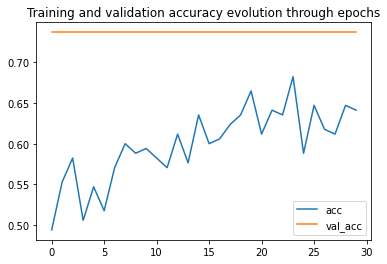

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy evolution through epochs')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

In [ ]:
model.evaluate(X_train,y_train)

6/6 [==============================] - 1s 121ms/step - loss: 0.2435 - accuracy: 0.6085


[0.24346180260181427, 0.6084656715393066]

In [ ]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 427ms/step - loss: 0.2463 - accuracy: 0.5455


[0.2463086098432541, 0.5454545617103577]